<a href="https://colab.research.google.com/github/sunhuanhuan920/ECE1512_2023F_ProjectRepo_Zhenhuan_Sun/blob/main/Project%20A/Project_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Task 1: Knowledge Distillation in MNIST Dataset**

# Question 1

(a). Transfer the knowledge from a large and cumbersome model to a model that is smaller and more suitable for deployment.

(b). The class probabilities produced by the cumbersome model.

(c).

\begin{equation}
\lim_{T \to \infty} \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)} = \frac{\exp(0)}{\sum_j \exp(0)} = \frac{1}{K}
\end{equation}

where $K$ denotes the number of classes. Thus, from this we can see that $T$ is a scaling factor that will make the probability distribution acorss all classes become closer to a uniform distribution.

We use $T$ to soften the probability distribution over classes, and capture and amplify nuanced information that cannot be captured by hard targets, such as one-hot vector.

By using a large value of $T$, the relative probabilities between classes become more discernible. From which, subtle information (knowledge), such as how the teacher model perceives the difference between classes and what mistakes the teacher model is more likely to make, can be acquired and utilized during knowledge distillation.

(d). The loss function comprises two parts, the first part, which is called distillation loss, is defined as

\begin{equation}
L^{(distillation)}(\mathbf{x}|T) = -\sum_{i=1}^K q_i(\mathbf{x}|T) \log(p_i(\mathbf{x}|T))
\end{equation}

where $q_i(\mathbf{x}|T)$ is the softened probability for class $i$ given input vector $\mathbf{x}$ and distillation temperature $T$ from the teacher model, and $p_i(\mathbf{x}|T)$ is the student model's softened probability for class $i$ given same input vector and distillation temperature. Cross entropy is used to measure the difference between the student's softened probability distribution and the teacher's softened probability distribution over all classes.

The second part, which is sometimes referred as classification loss, is defined as

\begin{equation}
L^{(classification)}(\mathbf{x}|T=1) = -\sum_{i=1}^K y_i \log(p_i(\mathbf{x}|T=1))
\end{equation}

where $y_i$ is the $i$ th element of the one-hot vector. Cross entropy is used to measure the difference between student model's unsoftened ($T = 1$) predicted probability distribution for different classes and the true class probability distribution, e.g., one-hot vector.

The combined loss function is defined as

\begin{equation}
L(\mathbf{x}|T) = \lambda T^2 \cdot L^{(distillation)}(\mathbf{x}|T) + (1 - \lambda) \cdot L^{(classification)}(\mathbf{x}|1)
\end{equation}

where weight parameter ($\lambda$), i.e.,task balance parameter, is introduced to combined the distillation loss and classification loss. In addition, the distillation loss is scaled by a factor of $T^2$ in the weighted sum to compensate for the gradient's down scale by a factor of $1/T^2$ due to the present of $T$ in the softmax function.

The task balance parameter governs the relative contribution of distillation loss and classification loss in the overall kownledge distillation process. When $\lambda$ equals to 1, the student model focuses on distillation and is trained only using the kownledge from the teacher model. When $\lambda$ equals to 0, the student model is trained regularly using labeled data. By adjusting $\lambda$ between $0$ and $1$, we can control how much of the teacher model's knowledge versus the acutal data we want the student to focus on during its training.

(e). The use of soft targets allows student model to account for the relative probabilites of different classes in the teacher model's output and have a deeper understanding of how teacher model generalizes. Thus, by performing knowledge distillation from teacher model to student model, we are essentially letting teacher model to teach student model how to generalize well, which is equivalent to the effect of regularization.

# Question 2

**Load Dataset**

In [10]:
# import tensorflow.compat.v2 as tf
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Union

# tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

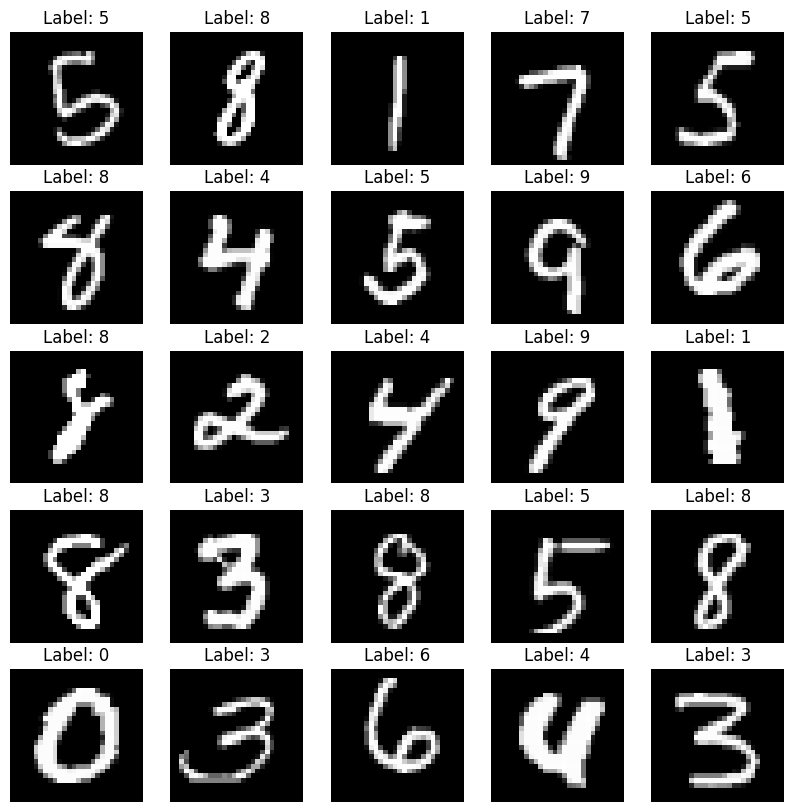

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from mnist_train
for images, labels in mnist_train.take(1):
    plt.figure(figsize=(10, 10))
    # Visualize the first 25 images from the batch
    for i in range(25):
        # print(images[i].shape)
        # print(labels[i].shape)
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title('Label: %d' % tf.argmax(labels[i]))
        plt.axis('off')
    plt.show()

**Model Creation**

In [17]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential([

    # Each image in MINIST dataset has shape of (28, 28, 1)
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),

    tf.keras.layers.Dropout(rate=0.5),
    # There are 10 classes in MINIST dataset
    tf.keras.layers.Dense(10)
])

# your code start from here for stpe 2


# Build fully connected student.
fc_model = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(units=784, activation='relu'),

    tf.keras.layers.Dense(units=784, activation='relu'),

    # There are 10 classes in MINIST dataset
    tf.keras.layers.Dense(10)
])

# your code start from here for step 2

# Question 3

**Teacher loss function**

In [18]:
@tf.function
def compute_teacher_loss(images, labels):
    """Compute subclass knowledge distillation teacher loss for given images
       and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    subclass_logits = cnn_model(images, training=True)

    # your code start from here for step 3
    # Compute cross-entropy loss for subclasses.
    cross_entropy_loss_value = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)
    )

    return cross_entropy_loss_value

**Student loss function**

In [31]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.8 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 3. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    """Compute distillation loss.

    This function computes cross entropy between softened logits and softened
    targets. The resulting loss is scaled by the squared temperature so that
    the gradient magnitude remains approximately constant as the temperature is
    changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
    a neural network."

    Args:
      teacher_logits: A Tensor of logits provided by the teacher.
      student_logits: A Tensor of logits provided by the student, of the same
        shape as `teacher_logits`.
      temperature: Temperature to use for distillation.

    Returns:
      A scalar Tensor containing the distillation loss.
    """
    # your code start from here for step 3
    soft_targets = tf.nn.softmax(teacher_logits / temperature)

    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
    """Compute subclass knowledge distillation student loss for given images
      and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    student_subclass_logits = fc_model(images, training=True)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass targets probabilities.

    # your code start from here for step 3

    teacher_subclass_logits = cnn_model(images, training=False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    # Compute cross-entropy loss with hard targets.

    # your code start from here for step 3

    cross_entropy_loss_value = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
    )

    combined_loss = ALPHA * distillation_loss_value + (1 - ALPHA) * cross_entropy_loss_value

    return combined_loss

# Question 4

**Train and evaluation**

In [32]:
NUM_EPOCHS = 12

@tf.function
def compute_num_correct(model, images, labels):
    """Compute number of correctly classified images in a batch.

    Args:
      model: Instance of tf.keras.Model.
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Number of correctly classified images.
    """
    class_logits = model(images, training=False)
    return tf.reduce_sum(
        tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
                tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
      model: Instance of tf.keras.Model.
      compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """

    # your code start from here for step 4
    # Initialize Adam optimizer with learning rate of 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(1, NUM_EPOCHS + 1):
      # Run training.
      print('Epoch {}: '.format(epoch), end='')
      for images, labels in mnist_train:
        # For backpropagation
        # Records the operations performed inside its block to compute gradients
        with tf.GradientTape() as tape:
          # your code start from here for step 4

          # Compute loss
          loss_value = compute_loss_fn(images, labels)

        # Use the recorded operations to compute the gradients
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Run evaluation.
      num_correct = 0
      num_total = builder.info.splits['test'].num_examples
      for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct_batch, _, _ = compute_num_correct(model, images, labels)
        num_correct += num_correct_batch
      print("Class_accuracy: " + '{:.2f}%'.format(
          num_correct / num_total * 100))

# Question 5

**Training models**

In [27]:
# your code start from here for step 5

# Train teacher model
print("Training Teacher Model")
train_and_evaluate(cnn_model, compute_teacher_loss)

# Train student model
print("\nTraining Student Model")
train_and_evaluate(fc_model, compute_student_loss)

Training Teacher Model
Epoch 1: Class_accuracy: 99.43%
Epoch 2: Class_accuracy: 99.37%
Epoch 3: Class_accuracy: 99.36%
Epoch 4: Class_accuracy: 99.33%
Epoch 5: Class_accuracy: 99.34%
Epoch 6: Class_accuracy: 99.32%
Epoch 7: Class_accuracy: 99.34%
Epoch 8: Class_accuracy: 99.31%
Epoch 9: Class_accuracy: 99.35%
Epoch 10: Class_accuracy: 99.27%
Epoch 11: Class_accuracy: 99.40%
Epoch 12: Class_accuracy: 99.34%

Training Student Model
Epoch 1: Class_accuracy: 98.93%
Epoch 2: Class_accuracy: 98.91%
Epoch 3: Class_accuracy: 98.83%
Epoch 4: Class_accuracy: 98.92%
Epoch 5: Class_accuracy: 98.89%
Epoch 6: Class_accuracy: 99.00%
Epoch 7: Class_accuracy: 98.85%
Epoch 8: Class_accuracy: 98.94%
Epoch 9: Class_accuracy: 98.98%
Epoch 10: Class_accuracy: 98.93%
Epoch 11: Class_accuracy: 98.94%
Epoch 12: Class_accuracy: 98.92%


# Question 6

**Test accuracy vs. tempreture curve**


Training the student model with T = 1...
Epoch 1: Class_accuracy: 98.56%
Epoch 2: Class_accuracy: 98.73%
Epoch 3: Class_accuracy: 98.81%
Epoch 4: Class_accuracy: 98.74%
Epoch 5: Class_accuracy: 98.82%
Epoch 6: Class_accuracy: 98.96%
Epoch 7: Class_accuracy: 98.98%
Epoch 8: Class_accuracy: 99.04%
Epoch 9: Class_accuracy: 99.00%
Epoch 10: Class_accuracy: 98.98%
Epoch 11: Class_accuracy: 98.77%
Epoch 12: Class_accuracy: 98.59%
Test accuracy: 0.98590

Training the student model with T = 2...
Epoch 1: Class_accuracy: 99.03%
Epoch 2: Class_accuracy: 98.96%
Epoch 3: Class_accuracy: 99.03%
Epoch 4: Class_accuracy: 98.99%
Epoch 5: Class_accuracy: 99.11%
Epoch 6: Class_accuracy: 99.06%
Epoch 7: Class_accuracy: 98.95%
Epoch 8: Class_accuracy: 99.03%
Epoch 9: Class_accuracy: 99.09%
Epoch 10: Class_accuracy: 99.07%
Epoch 11: Class_accuracy: 99.05%
Epoch 12: Class_accuracy: 99.06%
Test accuracy: 0.99060

Training the student model with T = 4...
Epoch 1: Class_accuracy: 99.03%
Epoch 2: Class_accurac

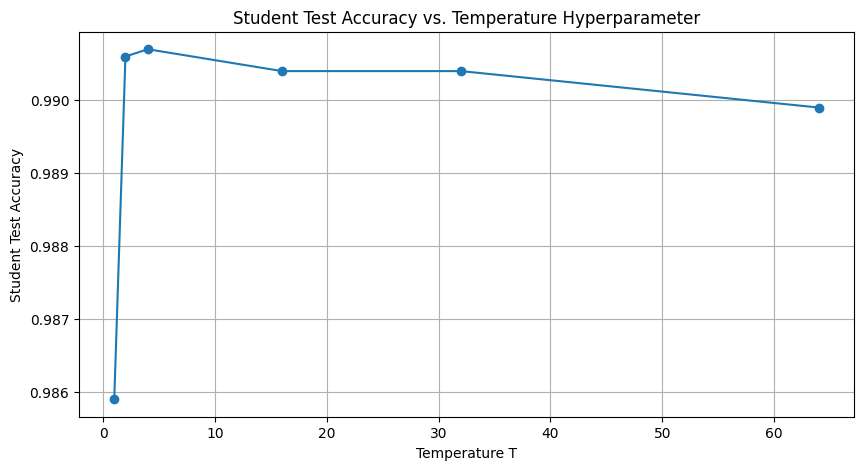

In [33]:
ALPHA = 0.5
temperatures = [1, 2, 4, 16, 32, 64]
accuracies = []

for T in temperatures:
    # Set global DISTILLATION_TEMPERATURE
    DISTILLATION_TEMPERATURE = T

    # Train and evaluate student model
    print(f"\nTraining the student model with T = {T}...")
    train_and_evaluate(fc_model, compute_student_loss)

    # Evaluate the student model
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
        num_correct_batch, _, _ = compute_num_correct(fc_model, images, labels)
        num_correct += num_correct_batch
    accuracy = num_correct / num_total
    accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.5f}")

# Plotting the curve
plt.figure(figsize=(10, 5))
plt.plot(temperatures, accuracies, marker='o')
plt.xlabel('Temperature T')
plt.ylabel('Student Test Accuracy')
plt.title('Student Test Accuracy vs. Temperature Hyperparameter')
plt.grid(True)
plt.show()

# **Task 2: Knowledge Distillation in MHIST Dataset**